# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Campo 20 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')

In [6]:
np.shape(campvectrain)

(7000, 2, 20, 20)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')

In [10]:
np.shape(campvectest)

(1000, 2, 20, 20)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(1000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')

In [14]:
np.shape(campvecval)

(2000, 2, 20, 20)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(2000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(2, 20, 20), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 20
SHUFFLE_BUFFER_SIZE = 20

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
model = Sequential()
model.add(Flatten(input_shape=(2, 20, 20)))
model.add(BatchNormalization())
model.add(Dense(100, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dense(100, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(100, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dense(50, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(50, activation='relu', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dropout(0.2))
model.add(Dense(50, activation='tanh', kernel_initializer='glorot_uniform', kernel_regularizer=l1(0.001)))
model.add(Dense(7, activation = custom_activation
               ))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 800)               0         
                                                                 
 batch_normalization (BatchN  (None, 800)              3200      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               80100     
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                        

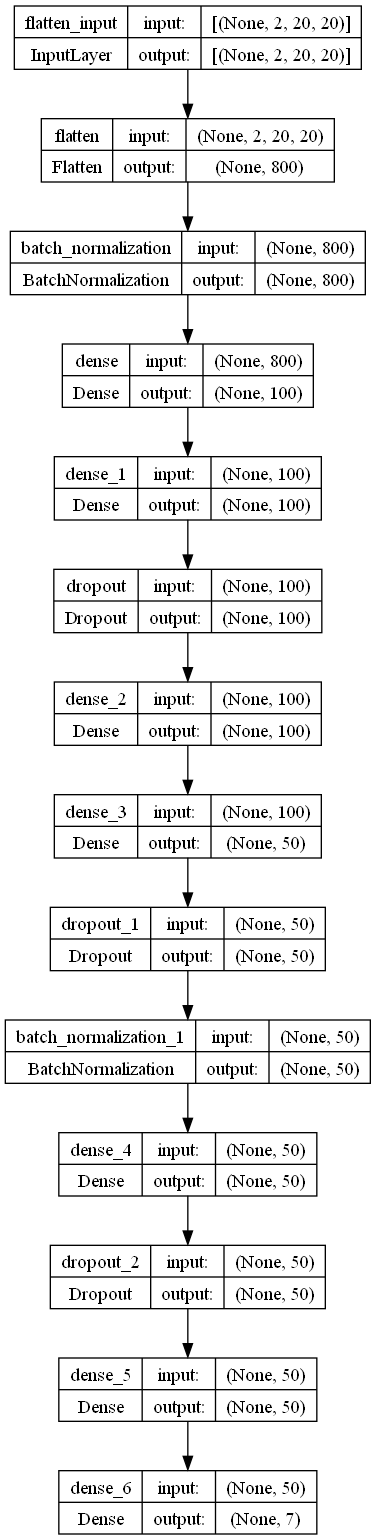

In [23]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [24]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [25]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [26]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [27]:
model.compile(optimizer=optimizer,
              loss= 'mean_squared_error',
              metrics=metrics)

In [28]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [29]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
350/350 [==============================] - 2s 2ms/step - loss: 10.3931 - a_1: 2.3512 - a_2: 2.5791 - b_1: 1.5652 - b_2: 1.5471 - d_1: 1.3340 - d_2: 1.3351 - n: 1.5173 - mean_metric: 0.4043 - val_loss: 7.0639 - val_a_1: 1.6340 - val_a_2: 1.4788 - val_b_1: 0.8923 - val_b_2: 0.9880 - val_d_1: 0.9009 - val_d_2: 0.7616 - val_n: 1.2525 - val_mean_metric: 0.2589 - lr: 0.0010
Epoch 2/1000
350/350 [==============================] - 1s 2ms/step - loss: 7.6000 - a_1: 1.7488 - a_2: 1.8365 - b_1: 1.3684 - b_2: 1.3793 - d_1: 1.2203 - d_2: 1.2631 - n: 1.3593 - mean_metric: 0.3366 - val_loss: 5.4865 - val_a_1: 1.2941 - val_a_2: 1.3411 - val_b_1: 0.9036 - val_b_2: 0.9252 - val_d_1: 0.7375 - val_d_2: 0.7072 - val_n: 1.2347 - val_mean_metric: 0.2339 - lr: 0.0010
Epoch 3/1000
350/350 [==============================] - 1s 2ms/step - loss: 6.3336 - a_1: 1.7059 - a_2: 1.7193 - b_1: 1.3241 - b_2: 1.3619 - d_1: 1.1413 - d_2: 1.1920 - n: 1.3484 - mean_metric: 0.3238 - val_loss: 4.6287 - val_a_1: 1.

350/350 [==============================] - 1s 2ms/step - loss: 2.4861 - a_1: 1.3808 - a_2: 1.4210 - b_1: 1.0542 - b_2: 1.0551 - d_1: 0.8765 - d_2: 0.8850 - n: 1.2843 - mean_metric: 0.2631 - val_loss: 1.6491 - val_a_1: 1.0388 - val_a_2: 1.0222 - val_b_1: 0.7340 - val_b_2: 0.6571 - val_d_1: 0.4820 - val_d_2: 0.5028 - val_n: 1.2095 - val_mean_metric: 0.1850 - lr: 0.0010
Epoch 44/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.5048 - a_1: 1.4072 - a_2: 1.4160 - b_1: 1.0468 - b_2: 1.0447 - d_1: 0.8618 - d_2: 0.9120 - n: 1.2804 - mean_metric: 0.2635 - val_loss: 1.6630 - val_a_1: 1.0154 - val_a_2: 1.0155 - val_b_1: 0.7179 - val_b_2: 0.6806 - val_d_1: 0.5189 - val_d_2: 0.6337 - val_n: 1.2010 - val_mean_metric: 0.1894 - lr: 0.0010
Epoch 45/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.4952 - a_1: 1.4034 - a_2: 1.4235 - b_1: 1.0377 - b_2: 1.0453 - d_1: 0.8772 - d_2: 0.8927 - n: 1.2814 - mean_metric: 0.2635 - val_loss: 1.6667 - val_a_1: 1.0297 - val_a

350/350 [==============================] - 1s 2ms/step - loss: 2.2933 - a_1: 1.3668 - a_2: 1.3110 - b_1: 1.0216 - b_2: 0.9195 - d_1: 0.8730 - d_2: 0.8783 - n: 1.2330 - mean_metric: 0.2515 - val_loss: 1.5046 - val_a_1: 0.9115 - val_a_2: 0.9617 - val_b_1: 0.6266 - val_b_2: 0.7041 - val_d_1: 0.5210 - val_d_2: 0.4436 - val_n: 1.1531 - val_mean_metric: 0.1743 - lr: 0.0010
Epoch 86/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.3021 - a_1: 1.3803 - a_2: 1.3183 - b_1: 1.0105 - b_2: 0.9095 - d_1: 0.8689 - d_2: 0.8908 - n: 1.2353 - mean_metric: 0.2520 - val_loss: 1.5299 - val_a_1: 0.9744 - val_a_2: 0.8636 - val_b_1: 0.6389 - val_b_2: 0.5431 - val_d_1: 0.7473 - val_d_2: 0.5806 - val_n: 1.1409 - val_mean_metric: 0.1797 - lr: 0.0010
Epoch 87/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.3251 - a_1: 1.3805 - a_2: 1.3201 - b_1: 1.0269 - b_2: 0.9384 - d_1: 0.8673 - d_2: 0.8852 - n: 1.2399 - mean_metric: 0.2534 - val_loss: 1.5728 - val_a_1: 0.9367 - val_a

350/350 [==============================] - 1s 2ms/step - loss: 2.2607 - a_1: 1.3458 - a_2: 1.2856 - b_1: 1.0013 - b_2: 0.9277 - d_1: 0.8661 - d_2: 0.8830 - n: 1.2312 - mean_metric: 0.2494 - val_loss: 1.4524 - val_a_1: 0.9753 - val_a_2: 0.9729 - val_b_1: 0.6131 - val_b_2: 0.5423 - val_d_1: 0.5584 - val_d_2: 0.5211 - val_n: 1.1365 - val_mean_metric: 0.1743 - lr: 0.0010
Epoch 128/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2608 - a_1: 1.3781 - a_2: 1.3010 - b_1: 1.0073 - b_2: 0.9138 - d_1: 0.8334 - d_2: 0.8811 - n: 1.2341 - mean_metric: 0.2498 - val_loss: 1.4846 - val_a_1: 0.9166 - val_a_2: 0.8802 - val_b_1: 0.6508 - val_b_2: 0.8267 - val_d_1: 0.4964 - val_d_2: 0.5205 - val_n: 1.1391 - val_mean_metric: 0.1779 - lr: 0.0010
Epoch 129/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2322 - a_1: 1.3631 - a_2: 1.2851 - b_1: 1.0174 - b_2: 0.8956 - d_1: 0.8588 - d_2: 0.8739 - n: 1.2171 - mean_metric: 0.2484 - val_loss: 1.5236 - val_a_1: 0.9449 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.2564 - a_1: 1.3523 - a_2: 1.2888 - b_1: 0.9911 - b_2: 0.9204 - d_1: 0.8644 - d_2: 0.8905 - n: 1.2266 - mean_metric: 0.2493 - val_loss: 1.4465 - val_a_1: 0.9401 - val_a_2: 0.9111 - val_b_1: 0.6455 - val_b_2: 0.5995 - val_d_1: 0.4582 - val_d_2: 0.5690 - val_n: 1.1392 - val_mean_metric: 0.1724 - lr: 0.0010
Epoch 170/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2539 - a_1: 1.3600 - a_2: 1.2804 - b_1: 1.0018 - b_2: 0.9267 - d_1: 0.8513 - d_2: 0.8865 - n: 1.2262 - mean_metric: 0.2492 - val_loss: 1.5270 - val_a_1: 1.1762 - val_a_2: 0.9403 - val_b_1: 0.6656 - val_b_2: 0.5886 - val_d_1: 0.4636 - val_d_2: 0.6283 - val_n: 1.1391 - val_mean_metric: 0.1835 - lr: 0.0010
Epoch 171/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2355 - a_1: 1.3341 - a_2: 1.2728 - b_1: 1.0070 - b_2: 0.9153 - d_1: 0.8629 - d_2: 0.9017 - n: 1.2240 - mean_metric: 0.2485 - val_loss: 1.4035 - val_a_1: 0.9972 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.2274 - a_1: 1.3392 - a_2: 1.2439 - b_1: 1.0174 - b_2: 0.9066 - d_1: 0.8886 - d_2: 0.8997 - n: 1.2186 - mean_metric: 0.2485 - val_loss: 1.4170 - val_a_1: 0.9721 - val_a_2: 0.8058 - val_b_1: 0.6274 - val_b_2: 0.5802 - val_d_1: 0.5461 - val_d_2: 0.5141 - val_n: 1.1302 - val_mean_metric: 0.1696 - lr: 0.0010
Epoch 212/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2083 - a_1: 1.3157 - a_2: 1.2508 - b_1: 1.0122 - b_2: 0.9020 - d_1: 0.8552 - d_2: 0.8978 - n: 1.2128 - mean_metric: 0.2463 - val_loss: 1.4141 - val_a_1: 0.9318 - val_a_2: 0.8338 - val_b_1: 0.6671 - val_b_2: 0.5434 - val_d_1: 0.5468 - val_d_2: 0.5153 - val_n: 1.1331 - val_mean_metric: 0.1694 - lr: 0.0010
Epoch 213/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2032 - a_1: 1.3093 - a_2: 1.2552 - b_1: 1.0113 - b_2: 0.9065 - d_1: 0.8509 - d_2: 0.8843 - n: 1.2173 - mean_metric: 0.2459 - val_loss: 1.5042 - val_a_1: 0.9047 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.2445 - a_1: 1.3331 - a_2: 1.2541 - b_1: 1.0292 - b_2: 0.9042 - d_1: 0.8489 - d_2: 0.8849 - n: 1.2179 - mean_metric: 0.2472 - val_loss: 1.6150 - val_a_1: 1.0337 - val_a_2: 0.9550 - val_b_1: 0.7918 - val_b_2: 0.6609 - val_d_1: 0.8782 - val_d_2: 0.5945 - val_n: 1.1349 - val_mean_metric: 0.1981 - lr: 0.0010
Epoch 254/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2242 - a_1: 1.3393 - a_2: 1.2458 - b_1: 1.0090 - b_2: 0.9319 - d_1: 0.8442 - d_2: 0.8933 - n: 1.2171 - mean_metric: 0.2473 - val_loss: 1.4353 - val_a_1: 0.9079 - val_a_2: 0.8255 - val_b_1: 0.8194 - val_b_2: 0.5438 - val_d_1: 0.4586 - val_d_2: 0.5324 - val_n: 1.1265 - val_mean_metric: 0.1707 - lr: 0.0010
Epoch 255/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1938 - a_1: 1.3235 - a_2: 1.2351 - b_1: 1.0272 - b_2: 0.9210 - d_1: 0.8563 - d_2: 0.8471 - n: 1.2136 - mean_metric: 0.2455 - val_loss: 1.5394 - val_a_1: 0.9576 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.2071 - a_1: 1.3152 - a_2: 1.2518 - b_1: 0.9984 - b_2: 0.9332 - d_1: 0.8660 - d_2: 0.8799 - n: 1.2081 - mean_metric: 0.2465 - val_loss: 1.4790 - val_a_1: 0.9601 - val_a_2: 0.9232 - val_b_1: 0.6559 - val_b_2: 0.4914 - val_d_1: 0.7631 - val_d_2: 0.6805 - val_n: 1.1216 - val_mean_metric: 0.1833 - lr: 0.0010
Epoch 296/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2381 - a_1: 1.3409 - a_2: 1.2605 - b_1: 1.0182 - b_2: 0.9307 - d_1: 0.8423 - d_2: 0.9141 - n: 1.2079 - mean_metric: 0.2488 - val_loss: 1.4593 - val_a_1: 0.9626 - val_a_2: 0.8835 - val_b_1: 0.5803 - val_b_2: 0.5524 - val_d_1: 0.4560 - val_d_2: 0.7282 - val_n: 1.1251 - val_mean_metric: 0.1731 - lr: 0.0010
Epoch 297/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2304 - a_1: 1.3252 - a_2: 1.2381 - b_1: 1.0292 - b_2: 0.9195 - d_1: 0.8693 - d_2: 0.8717 - n: 1.2132 - mean_metric: 0.2468 - val_loss: 1.4891 - val_a_1: 1.0146 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.1515 - a_1: 1.3032 - a_2: 1.2299 - b_1: 0.9987 - b_2: 0.9096 - d_1: 0.8342 - d_2: 0.8670 - n: 1.1961 - mean_metric: 0.2428 - val_loss: 1.3560 - val_a_1: 0.8846 - val_a_2: 0.7748 - val_b_1: 0.6746 - val_b_2: 0.5261 - val_d_1: 0.5144 - val_d_2: 0.4423 - val_n: 1.1146 - val_mean_metric: 0.1615 - lr: 0.0010
Epoch 338/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1714 - a_1: 1.3271 - a_2: 1.2237 - b_1: 0.9908 - b_2: 0.9110 - d_1: 0.8498 - d_2: 0.8833 - n: 1.2005 - mean_metric: 0.2443 - val_loss: 1.3857 - val_a_1: 0.8941 - val_a_2: 0.8266 - val_b_1: 0.7311 - val_b_2: 0.5032 - val_d_1: 0.5221 - val_d_2: 0.5674 - val_n: 1.1143 - val_mean_metric: 0.1689 - lr: 0.0010
Epoch 339/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2129 - a_1: 1.3561 - a_2: 1.2324 - b_1: 1.0168 - b_2: 0.9017 - d_1: 0.8484 - d_2: 0.8778 - n: 1.2029 - mean_metric: 0.2461 - val_loss: 1.4264 - val_a_1: 0.8684 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.1342 - a_1: 1.3101 - a_2: 1.2192 - b_1: 0.9978 - b_2: 0.9001 - d_1: 0.8390 - d_2: 0.8643 - n: 1.1868 - mean_metric: 0.2419 - val_loss: 1.5418 - val_a_1: 0.9320 - val_a_2: 0.8966 - val_b_1: 0.6346 - val_b_2: 0.7284 - val_d_1: 0.9034 - val_d_2: 0.5834 - val_n: 1.1018 - val_mean_metric: 0.1892 - lr: 0.0010
Epoch 380/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.2045 - a_1: 1.3092 - a_2: 1.2399 - b_1: 1.0146 - b_2: 0.9178 - d_1: 0.8211 - d_2: 0.8921 - n: 1.1970 - mean_metric: 0.2445 - val_loss: 1.4350 - val_a_1: 0.9794 - val_a_2: 0.8369 - val_b_1: 0.7158 - val_b_2: 0.5552 - val_d_1: 0.3849 - val_d_2: 0.5764 - val_n: 1.1157 - val_mean_metric: 0.1691 - lr: 0.0010
Epoch 381/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1710 - a_1: 1.3226 - a_2: 1.2249 - b_1: 1.0169 - b_2: 0.9098 - d_1: 0.8491 - d_2: 0.8815 - n: 1.1862 - mean_metric: 0.2445 - val_loss: 1.3886 - val_a_1: 0.8941 - val

350/350 [==============================] - 1s 2ms/step - loss: 2.1836 - a_1: 1.3272 - a_2: 1.2296 - b_1: 1.0023 - b_2: 0.8951 - d_1: 0.8263 - d_2: 0.8910 - n: 1.1917 - mean_metric: 0.2434 - val_loss: 1.5223 - val_a_1: 0.9479 - val_a_2: 0.9199 - val_b_1: 0.6211 - val_b_2: 0.7205 - val_d_1: 0.6591 - val_d_2: 0.6040 - val_n: 1.1138 - val_mean_metric: 0.1829 - lr: 9.6700e-04
Epoch 422/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1886 - a_1: 1.3351 - a_2: 1.2514 - b_1: 1.0174 - b_2: 0.9224 - d_1: 0.8386 - d_2: 0.8672 - n: 1.1926 - mean_metric: 0.2458 - val_loss: 1.3660 - val_a_1: 0.9028 - val_a_2: 0.8568 - val_b_1: 0.6710 - val_b_2: 0.5263 - val_d_1: 0.4438 - val_d_2: 0.4734 - val_n: 1.1032 - val_mean_metric: 0.1631 - lr: 9.6535e-04
Epoch 423/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1762 - a_1: 1.3278 - a_2: 1.2255 - b_1: 1.0207 - b_2: 0.9012 - d_1: 0.8477 - d_2: 0.8662 - n: 1.1925 - mean_metric: 0.2441 - val_loss: 1.4184 - val_a_1: 0.87

350/350 [==============================] - 1s 2ms/step - loss: 2.1456 - a_1: 1.3141 - a_2: 1.2161 - b_1: 1.0194 - b_2: 0.9067 - d_1: 0.8225 - d_2: 0.8745 - n: 1.1822 - mean_metric: 0.2426 - val_loss: 1.4502 - val_a_1: 0.9788 - val_a_2: 0.9583 - val_b_1: 0.6449 - val_b_2: 0.5129 - val_d_1: 0.5886 - val_d_2: 0.5936 - val_n: 1.1125 - val_mean_metric: 0.1765 - lr: 8.9770e-04
Epoch 464/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1816 - a_1: 1.3116 - a_2: 1.2510 - b_1: 1.0161 - b_2: 0.8925 - d_1: 0.8417 - d_2: 0.8676 - n: 1.1882 - mean_metric: 0.2436 - val_loss: 1.4547 - val_a_1: 1.0056 - val_a_2: 0.8465 - val_b_1: 0.7503 - val_b_2: 0.5614 - val_d_1: 0.6130 - val_d_2: 0.5124 - val_n: 1.1060 - val_mean_metric: 0.1767 - lr: 8.9605e-04
Epoch 465/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1685 - a_1: 1.3239 - a_2: 1.2202 - b_1: 1.0245 - b_2: 0.9146 - d_1: 0.8321 - d_2: 0.8538 - n: 1.1888 - mean_metric: 0.2432 - val_loss: 1.3904 - val_a_1: 0.98

350/350 [==============================] - 1s 2ms/step - loss: 2.1487 - a_1: 1.2909 - a_2: 1.2186 - b_1: 1.0083 - b_2: 0.8931 - d_1: 0.8428 - d_2: 0.8792 - n: 1.1841 - mean_metric: 0.2421 - val_loss: 1.5958 - val_a_1: 0.9148 - val_a_2: 1.3578 - val_b_1: 0.6464 - val_b_2: 0.6334 - val_d_1: 0.6921 - val_d_2: 0.6489 - val_n: 1.1016 - val_mean_metric: 0.1964 - lr: 8.2840e-04
Epoch 506/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1224 - a_1: 1.2938 - a_2: 1.2271 - b_1: 0.9969 - b_2: 0.8900 - d_1: 0.8408 - d_2: 0.8476 - n: 1.1868 - mean_metric: 0.2410 - val_loss: 1.3556 - val_a_1: 0.8922 - val_a_2: 0.8894 - val_b_1: 0.6712 - val_b_2: 0.5473 - val_d_1: 0.4560 - val_d_2: 0.4210 - val_n: 1.1134 - val_mean_metric: 0.1635 - lr: 8.2675e-04
Epoch 507/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1330 - a_1: 1.3128 - a_2: 1.2316 - b_1: 0.9942 - b_2: 0.8888 - d_1: 0.8463 - d_2: 0.8580 - n: 1.1900 - mean_metric: 0.2422 - val_loss: 1.3473 - val_a_1: 0.82

350/350 [==============================] - 1s 2ms/step - loss: 2.1188 - a_1: 1.3202 - a_2: 1.2104 - b_1: 0.9815 - b_2: 0.8823 - d_1: 0.8450 - d_2: 0.8637 - n: 1.1849 - mean_metric: 0.2409 - val_loss: 1.3695 - val_a_1: 1.0289 - val_a_2: 0.8428 - val_b_1: 0.6069 - val_b_2: 0.5705 - val_d_1: 0.4164 - val_d_2: 0.5055 - val_n: 1.1118 - val_mean_metric: 0.1665 - lr: 7.5910e-04
Epoch 548/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1020 - a_1: 1.3056 - a_2: 1.2150 - b_1: 0.9984 - b_2: 0.8641 - d_1: 0.8234 - d_2: 0.8687 - n: 1.1806 - mean_metric: 0.2399 - val_loss: 1.3123 - val_a_1: 0.8302 - val_a_2: 0.8072 - val_b_1: 0.6256 - val_b_2: 0.5107 - val_d_1: 0.4206 - val_d_2: 0.5367 - val_n: 1.1034 - val_mean_metric: 0.1583 - lr: 7.5745e-04
Epoch 549/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.1432 - a_1: 1.3075 - a_2: 1.2111 - b_1: 1.0071 - b_2: 0.8915 - d_1: 0.8525 - d_2: 0.8788 - n: 1.1890 - mean_metric: 0.2426 - val_loss: 1.3701 - val_a_1: 0.91

350/350 [==============================] - 1s 2ms/step - loss: 2.1260 - a_1: 1.3121 - a_2: 1.2116 - b_1: 1.0223 - b_2: 0.8675 - d_1: 0.8511 - d_2: 0.8611 - n: 1.1915 - mean_metric: 0.2419 - val_loss: 1.3198 - val_a_1: 0.8962 - val_a_2: 0.8889 - val_b_1: 0.6232 - val_b_2: 0.5167 - val_d_1: 0.4187 - val_d_2: 0.4025 - val_n: 1.1053 - val_mean_metric: 0.1589 - lr: 6.8980e-04
Epoch 590/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0885 - a_1: 1.2983 - a_2: 1.2151 - b_1: 0.9772 - b_2: 0.8742 - d_1: 0.8366 - d_2: 0.8462 - n: 1.1849 - mean_metric: 0.2392 - val_loss: 1.3790 - val_a_1: 0.8870 - val_a_2: 0.7913 - val_b_1: 0.5886 - val_b_2: 0.5297 - val_d_1: 0.7030 - val_d_2: 0.6761 - val_n: 1.1040 - val_mean_metric: 0.1729 - lr: 6.8815e-04
Epoch 591/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0674 - a_1: 1.2903 - a_2: 1.1786 - b_1: 0.9881 - b_2: 0.8748 - d_1: 0.8351 - d_2: 0.8571 - n: 1.1801 - mean_metric: 0.2382 - val_loss: 1.4099 - val_a_1: 1.00

350/350 [==============================] - 1s 2ms/step - loss: 2.0496 - a_1: 1.2874 - a_2: 1.1730 - b_1: 0.9757 - b_2: 0.8812 - d_1: 0.8410 - d_2: 0.8472 - n: 1.1824 - mean_metric: 0.2377 - val_loss: 1.3671 - val_a_1: 0.8849 - val_a_2: 0.8160 - val_b_1: 0.6752 - val_b_2: 0.6520 - val_d_1: 0.6076 - val_d_2: 0.4254 - val_n: 1.1081 - val_mean_metric: 0.1693 - lr: 6.2050e-04
Epoch 632/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0713 - a_1: 1.3248 - a_2: 1.1878 - b_1: 0.9919 - b_2: 0.8635 - d_1: 0.8218 - d_2: 0.8357 - n: 1.1882 - mean_metric: 0.2387 - val_loss: 1.3866 - val_a_1: 0.9163 - val_a_2: 0.8108 - val_b_1: 0.8293 - val_b_2: 0.5360 - val_d_1: 0.4755 - val_d_2: 0.5342 - val_n: 1.1073 - val_mean_metric: 0.1705 - lr: 6.1885e-04
Epoch 633/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0733 - a_1: 1.2805 - a_2: 1.2161 - b_1: 0.9963 - b_2: 0.8921 - d_1: 0.8331 - d_2: 0.8420 - n: 1.1859 - mean_metric: 0.2395 - val_loss: 1.3783 - val_a_1: 1.01

350/350 [==============================] - 1s 2ms/step - loss: 2.0527 - a_1: 1.2800 - a_2: 1.2127 - b_1: 0.9920 - b_2: 0.8670 - d_1: 0.8063 - d_2: 0.8535 - n: 1.1834 - mean_metric: 0.2378 - val_loss: 1.2761 - val_a_1: 0.7949 - val_a_2: 0.7708 - val_b_1: 0.5892 - val_b_2: 0.5345 - val_d_1: 0.4977 - val_d_2: 0.4613 - val_n: 1.1104 - val_mean_metric: 0.1559 - lr: 5.5120e-04
Epoch 674/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0526 - a_1: 1.2961 - a_2: 1.1981 - b_1: 0.9841 - b_2: 0.8664 - d_1: 0.8155 - d_2: 0.8291 - n: 1.1795 - mean_metric: 0.2371 - val_loss: 1.3004 - val_a_1: 0.8816 - val_a_2: 0.8691 - val_b_1: 0.6518 - val_b_2: 0.4952 - val_d_1: 0.3732 - val_d_2: 0.4334 - val_n: 1.1021 - val_mean_metric: 0.1576 - lr: 5.4955e-04
Epoch 675/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0677 - a_1: 1.3058 - a_2: 1.1938 - b_1: 0.9936 - b_2: 0.8542 - d_1: 0.8219 - d_2: 0.8399 - n: 1.1810 - mean_metric: 0.2380 - val_loss: 1.2944 - val_a_1: 0.81

350/350 [==============================] - 1s 2ms/step - loss: 2.0284 - a_1: 1.2757 - a_2: 1.1958 - b_1: 0.9841 - b_2: 0.8613 - d_1: 0.8048 - d_2: 0.8534 - n: 1.1797 - mean_metric: 0.2367 - val_loss: 1.2549 - val_a_1: 0.8788 - val_a_2: 0.8022 - val_b_1: 0.6198 - val_b_2: 0.5405 - val_d_1: 0.3841 - val_d_2: 0.4203 - val_n: 1.1048 - val_mean_metric: 0.1556 - lr: 4.8190e-04
Epoch 716/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0362 - a_1: 1.2701 - a_2: 1.1923 - b_1: 0.9992 - b_2: 0.8691 - d_1: 0.8078 - d_2: 0.8573 - n: 1.1785 - mean_metric: 0.2373 - val_loss: 1.3709 - val_a_1: 0.8722 - val_a_2: 0.8700 - val_b_1: 0.6408 - val_b_2: 0.8073 - val_d_1: 0.4491 - val_d_2: 0.5002 - val_n: 1.1102 - val_mean_metric: 0.1720 - lr: 4.8025e-04
Epoch 717/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0218 - a_1: 1.2855 - a_2: 1.1710 - b_1: 0.9802 - b_2: 0.8465 - d_1: 0.8125 - d_2: 0.8505 - n: 1.1793 - mean_metric: 0.2358 - val_loss: 1.2414 - val_a_1: 0.82

350/350 [==============================] - 1s 2ms/step - loss: 2.0017 - a_1: 1.2743 - a_2: 1.1698 - b_1: 0.9530 - b_2: 0.8759 - d_1: 0.8122 - d_2: 0.8531 - n: 1.1815 - mean_metric: 0.2355 - val_loss: 1.2586 - val_a_1: 0.8664 - val_a_2: 0.8124 - val_b_1: 0.5946 - val_b_2: 0.5888 - val_d_1: 0.3836 - val_d_2: 0.3856 - val_n: 1.1076 - val_mean_metric: 0.1552 - lr: 4.1260e-04
Epoch 758/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0254 - a_1: 1.2831 - a_2: 1.1884 - b_1: 0.9844 - b_2: 0.8590 - d_1: 0.8244 - d_2: 0.8280 - n: 1.1877 - mean_metric: 0.2367 - val_loss: 1.2795 - val_a_1: 0.9144 - val_a_2: 0.8580 - val_b_1: 0.5894 - val_b_2: 0.6775 - val_d_1: 0.4156 - val_d_2: 0.4118 - val_n: 1.1113 - val_mean_metric: 0.1631 - lr: 4.1095e-04
Epoch 759/1000
350/350 [==============================] - 1s 2ms/step - loss: 2.0156 - a_1: 1.2749 - a_2: 1.1886 - b_1: 0.9889 - b_2: 0.8702 - d_1: 0.7979 - d_2: 0.8247 - n: 1.1793 - mean_metric: 0.2356 - val_loss: 1.2852 - val_a_1: 0.89

350/350 [==============================] - 1s 2ms/step - loss: 2.0114 - a_1: 1.2901 - a_2: 1.1882 - b_1: 0.9876 - b_2: 0.8685 - d_1: 0.8063 - d_2: 0.8219 - n: 1.1793 - mean_metric: 0.2362 - val_loss: 1.2728 - val_a_1: 0.8430 - val_a_2: 0.7756 - val_b_1: 0.5972 - val_b_2: 0.5342 - val_d_1: 0.4029 - val_d_2: 0.6159 - val_n: 1.1051 - val_mean_metric: 0.1596 - lr: 3.4330e-04
Epoch 800/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9996 - a_1: 1.3053 - a_2: 1.1712 - b_1: 0.9590 - b_2: 0.8457 - d_1: 0.7916 - d_2: 0.8338 - n: 1.1816 - mean_metric: 0.2345 - val_loss: 1.2431 - val_a_1: 0.8375 - val_a_2: 0.8270 - val_b_1: 0.5916 - val_b_2: 0.4922 - val_d_1: 0.3340 - val_d_2: 0.4385 - val_n: 1.1020 - val_mean_metric: 0.1515 - lr: 3.4165e-04
Epoch 801/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9892 - a_1: 1.2748 - a_2: 1.1782 - b_1: 0.9662 - b_2: 0.8441 - d_1: 0.8034 - d_2: 0.8404 - n: 1.1779 - mean_metric: 0.2343 - val_loss: 1.2410 - val_a_1: 0.89

350/350 [==============================] - 1s 2ms/step - loss: 1.9671 - a_1: 1.2750 - a_2: 1.1759 - b_1: 0.9569 - b_2: 0.8398 - d_1: 0.8048 - d_2: 0.8267 - n: 1.1757 - mean_metric: 0.2331 - val_loss: 1.2114 - val_a_1: 0.8529 - val_a_2: 0.7926 - val_b_1: 0.5740 - val_b_2: 0.5180 - val_d_1: 0.3966 - val_d_2: 0.3938 - val_n: 1.1007 - val_mean_metric: 0.1517 - lr: 2.7400e-04
Epoch 842/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9721 - a_1: 1.2826 - a_2: 1.1467 - b_1: 0.9677 - b_2: 0.8694 - d_1: 0.8083 - d_2: 0.8370 - n: 1.1780 - mean_metric: 0.2345 - val_loss: 1.1938 - val_a_1: 0.8111 - val_a_2: 0.7439 - val_b_1: 0.6114 - val_b_2: 0.4932 - val_d_1: 0.3577 - val_d_2: 0.4246 - val_n: 1.0998 - val_mean_metric: 0.1488 - lr: 2.7235e-04
Epoch 843/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9456 - a_1: 1.2575 - a_2: 1.1628 - b_1: 0.9459 - b_2: 0.8414 - d_1: 0.8065 - d_2: 0.8292 - n: 1.1759 - mean_metric: 0.2321 - val_loss: 1.2193 - val_a_1: 0.83

350/350 [==============================] - 1s 2ms/step - loss: 1.9658 - a_1: 1.2685 - a_2: 1.1441 - b_1: 1.0003 - b_2: 0.8556 - d_1: 0.7925 - d_2: 0.8261 - n: 1.1807 - mean_metric: 0.2335 - val_loss: 1.2260 - val_a_1: 0.8349 - val_a_2: 0.8545 - val_b_1: 0.5709 - val_b_2: 0.5141 - val_d_1: 0.3927 - val_d_2: 0.3906 - val_n: 1.1061 - val_mean_metric: 0.1529 - lr: 2.0470e-04
Epoch 884/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9486 - a_1: 1.2378 - a_2: 1.1748 - b_1: 0.9575 - b_2: 0.8591 - d_1: 0.8026 - d_2: 0.8280 - n: 1.1753 - mean_metric: 0.2327 - val_loss: 1.1982 - val_a_1: 0.8257 - val_a_2: 0.7528 - val_b_1: 0.5704 - val_b_2: 0.5218 - val_d_1: 0.3974 - val_d_2: 0.4006 - val_n: 1.1038 - val_mean_metric: 0.1498 - lr: 2.0305e-04
Epoch 885/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9663 - a_1: 1.2617 - a_2: 1.1655 - b_1: 0.9630 - b_2: 0.8553 - d_1: 0.7891 - d_2: 0.8459 - n: 1.1810 - mean_metric: 0.2336 - val_loss: 1.1913 - val_a_1: 0.85

350/350 [==============================] - 1s 2ms/step - loss: 1.9471 - a_1: 1.2354 - a_2: 1.1683 - b_1: 0.9622 - b_2: 0.8430 - d_1: 0.8165 - d_2: 0.8324 - n: 1.1788 - mean_metric: 0.2326 - val_loss: 1.1820 - val_a_1: 0.8116 - val_a_2: 0.7699 - val_b_1: 0.5551 - val_b_2: 0.4764 - val_d_1: 0.3902 - val_d_2: 0.3842 - val_n: 1.1028 - val_mean_metric: 0.1471 - lr: 1.3540e-04
Epoch 926/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9269 - a_1: 1.2467 - a_2: 1.1469 - b_1: 0.9498 - b_2: 0.8544 - d_1: 0.8138 - d_2: 0.7978 - n: 1.1744 - mean_metric: 0.2309 - val_loss: 1.1828 - val_a_1: 0.8008 - val_a_2: 0.7386 - val_b_1: 0.5958 - val_b_2: 0.4953 - val_d_1: 0.3380 - val_d_2: 0.4391 - val_n: 1.1018 - val_mean_metric: 0.1478 - lr: 1.3375e-04
Epoch 927/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9294 - a_1: 1.2373 - a_2: 1.1494 - b_1: 0.9629 - b_2: 0.8331 - d_1: 0.8065 - d_2: 0.8351 - n: 1.1716 - mean_metric: 0.2315 - val_loss: 1.2054 - val_a_1: 0.78

350/350 [==============================] - 1s 2ms/step - loss: 1.9068 - a_1: 1.2489 - a_2: 1.1524 - b_1: 0.9548 - b_2: 0.8169 - d_1: 0.7739 - d_2: 0.8160 - n: 1.1728 - mean_metric: 0.2293 - val_loss: 1.1729 - val_a_1: 0.8205 - val_a_2: 0.7421 - val_b_1: 0.5570 - val_b_2: 0.4736 - val_d_1: 0.3518 - val_d_2: 0.3779 - val_n: 1.1001 - val_mean_metric: 0.1449 - lr: 6.6100e-05
Epoch 968/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9110 - a_1: 1.2510 - a_2: 1.1424 - b_1: 0.9461 - b_2: 0.8480 - d_1: 0.7926 - d_2: 0.7904 - n: 1.1801 - mean_metric: 0.2300 - val_loss: 1.1802 - val_a_1: 0.8354 - val_a_2: 0.7348 - val_b_1: 0.5760 - val_b_2: 0.4771 - val_d_1: 0.3631 - val_d_2: 0.3954 - val_n: 1.1014 - val_mean_metric: 0.1469 - lr: 6.4450e-05
Epoch 969/1000
350/350 [==============================] - 1s 2ms/step - loss: 1.9258 - a_1: 1.2546 - a_2: 1.1502 - b_1: 0.9670 - b_2: 0.8491 - d_1: 0.8139 - d_2: 0.8067 - n: 1.1753 - mean_metric: 0.2321 - val_loss: 1.1784 - val_a_1: 0.81

# Analizamos accuracy y loss

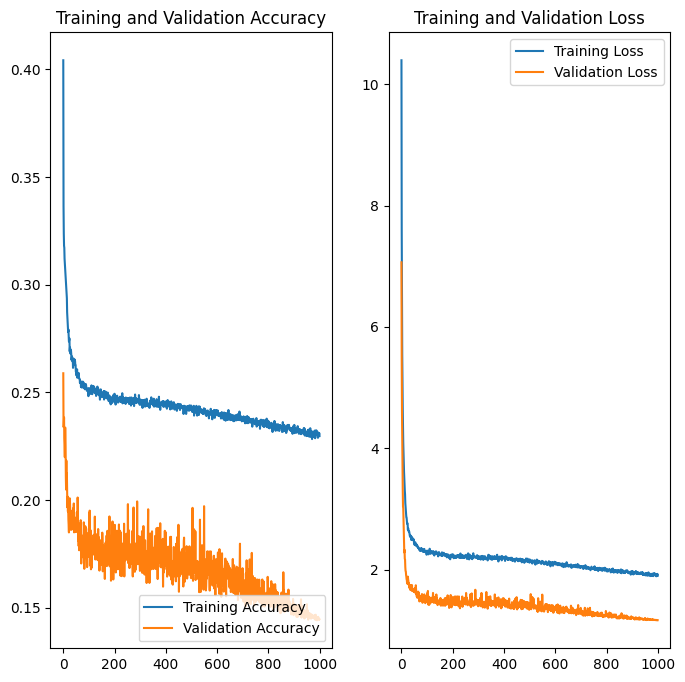

In [30]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

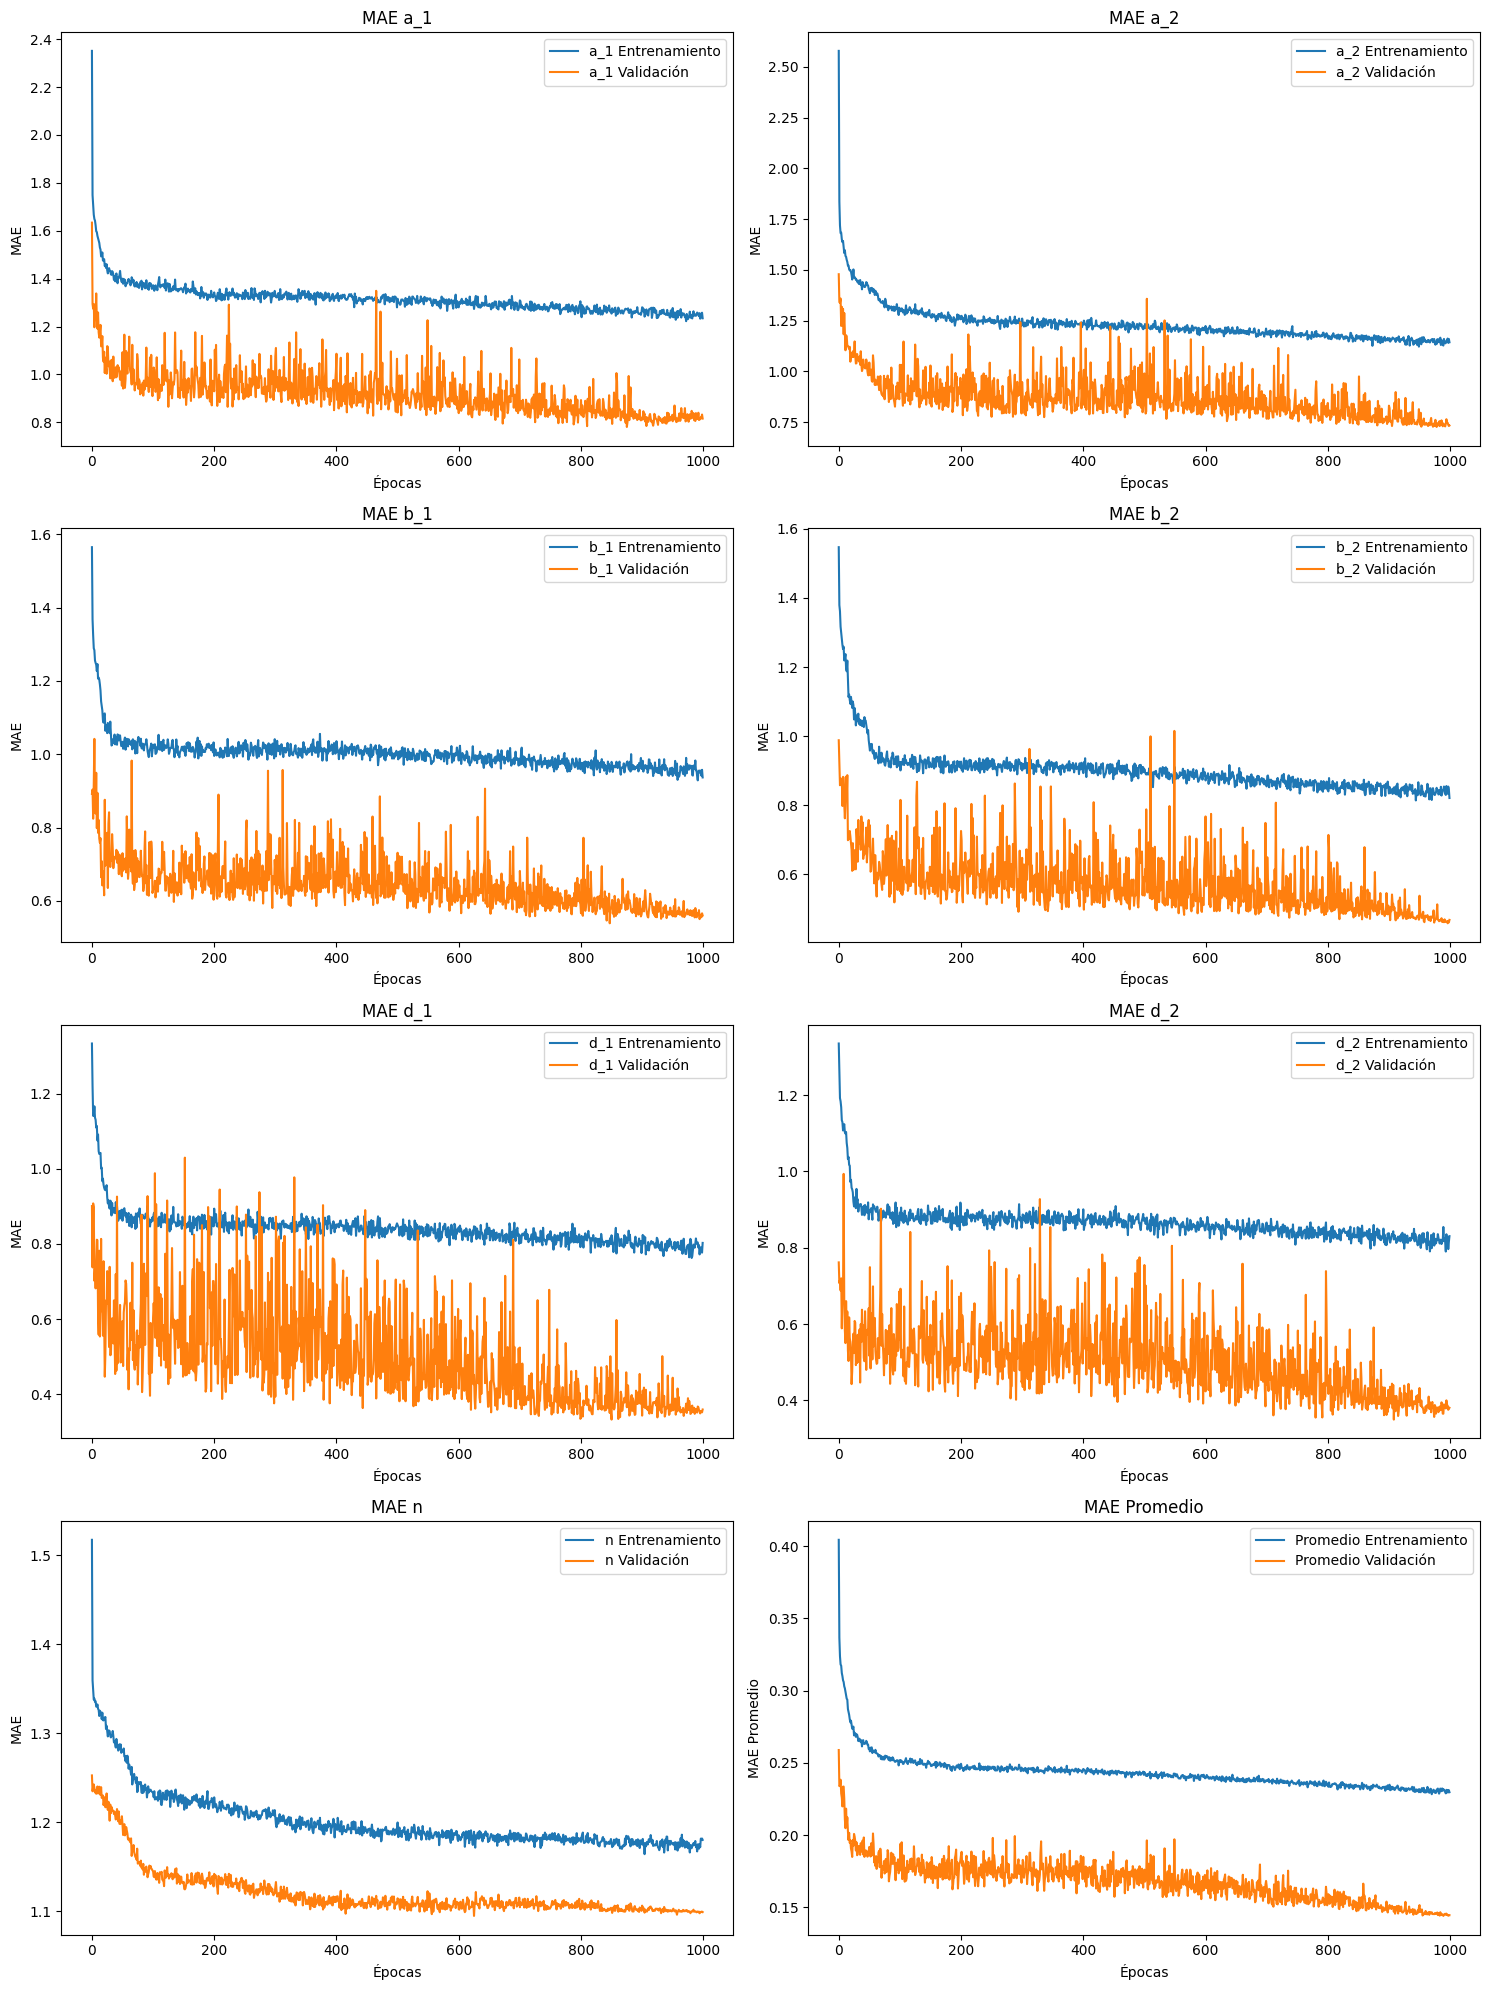

In [31]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [32]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    campvectest, coefcampvectest)

32/32 [==============================] - 0s 903us/step - loss: 1.1854 - a_1: 0.8023 - a_2: 0.7479 - b_1: 0.5647 - b_2: 0.4691 - d_1: 0.3685 - d_2: 0.3815 - n: 1.1533 - mean_metric: 0.1471


In [33]:
predictions = model.predict(campvectest)

32/32 [==============================] - 0s 677us/step


In [34]:
print(coefcampvectest[0,:])
print(predictions[0,:])
from sklearn.metrics import mean_absolute_error
print(np.sum(coefcampvectest, axis=-1))

mae1 = mean_absolute_error(coefcampvectest[0,:], predictions[0,:])
mae1

[ 7  2 10  1 10  0  1]
[7.7473125  1.8148634  9.199808   0.85574836 9.288832   0.7990366
 2.916911  ]
[31 32 28 49 25 38 26 42 31 27 24 18 37 33 38 30 24 36 37 38 36 33 20 37
 24 35 39 26 22 26 39 26 38 42 17 23 26 25 36 24 42 34 42 29 38 28 41 30
 34 35 42 16 26 28 40 28 32 40 28 35 28 38 34 32 42 39 38 29 33 38 34 30
 32 39 32 27 31 38 22 36 29 30 35 32 43 32 29 30 41 22 23 47 31 26 34 19
 29 42 30 22 33 38 25 29 36 41 34 40 32 35 40 39 31 38 21 37 43 40 30 41
 31 29 40 31 34 36 54 26 39 29 50 26 47 33 44 11 47 27 33 18 32 43 36 34
 30 34 38 46 24 32 21 48 41 44 42 40 35 29 34 31 33 28 37 30 29 38 35 33
 32 25 38 35 25 27 21 28 38 40 23 38 34 22 42 37 33 20 40 22 35 34 24 33
 37 31 35 31 28 23 36 34 40 25 30 31 34 39 26 26 37 36 45 34 28 30 39 37
 37 35 33 45 31 35 37 31 38 27 35 29 23 51 20 25 31 24 37 43 27 25 27 37
 26 36 36 39 34 23 24 44 31 30 43 41 31 32 40 28 40 32 36 24 47 44 20 28
 29 35 27 30 27 37 53 43 47 46 21 20 20 31 39 28 38 26 36 41 27 30 50 33
 34 37 27 35 23 37 39 

0.7577154891831535

In [35]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefcampvectest, predictions)

# Calcula la desviación estándar del error
error = coefcampvectest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 0.6399012011076722, Desviación estándar del error: 1.01007957614984, Error absoluto máximo: 6.775707006454468


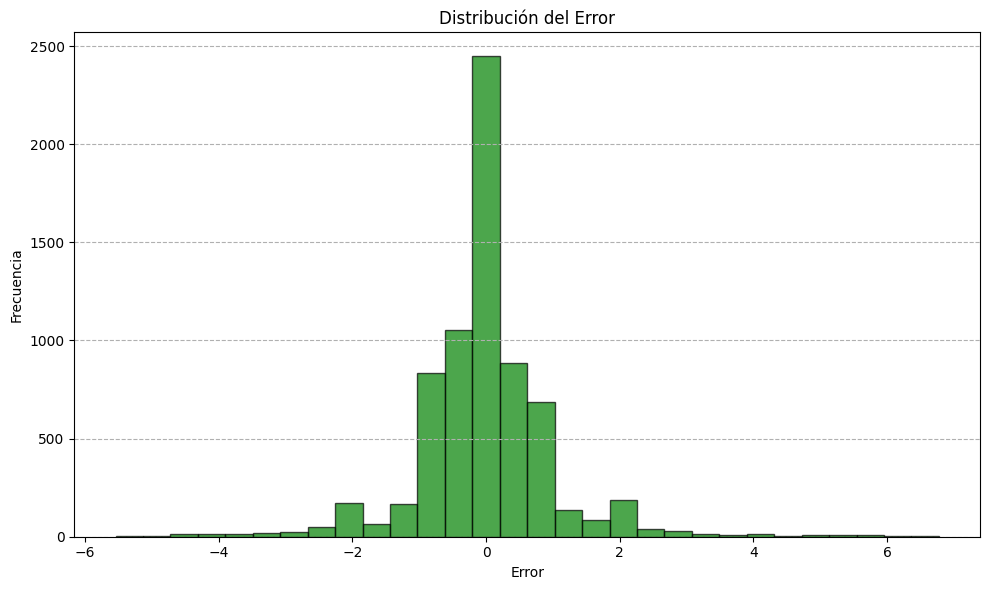

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [37]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefcampvectest - predictions)

# Calcula el error para cada dato
error = coefcampvectest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefcampvectest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")


MAE relativo: 0.15089793724351552
Desviación estándar del error relativo: 0.0642506988326365
Error absoluto máximo relativo: 0.32236347198486326


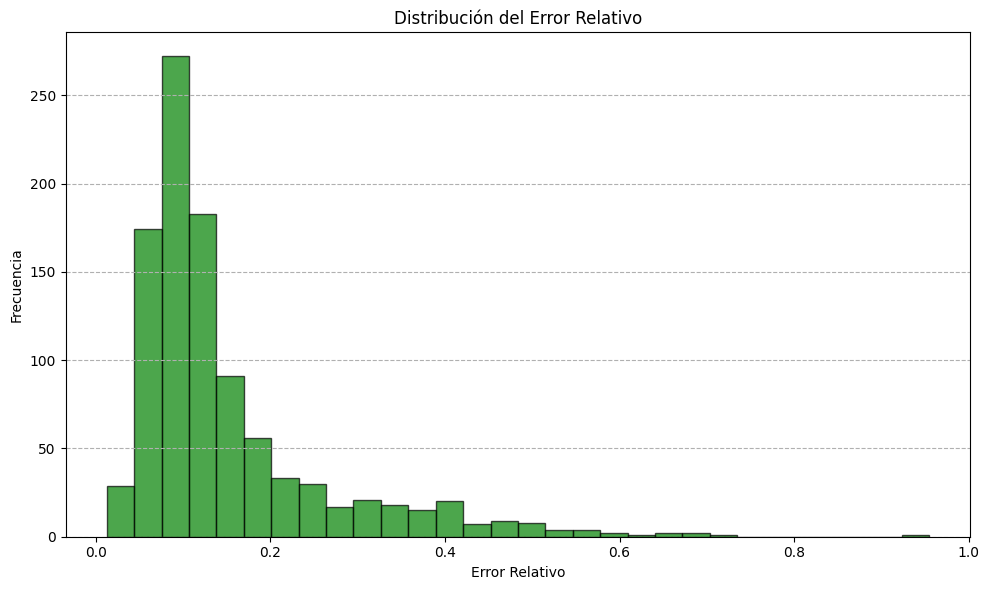

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

# Guardamos los datos Accuracy y Loss

In [39]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 20,50/historycampvec20.csv', index=False)

# Guardamos el modelo

In [40]:
path_to_save = '../../../Modelos/Modelos 20,50/'

In [41]:
model.save(path_to_save + '/campovectorial20.h5')

# Importamos el modelo

In [24]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [25]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [26]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'custom_activation':custom_activation, 'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)

new_model = keras.models.load_model('../../../Modelos/Modelos 20,50/campovectorial20.h5', custom_objects= custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [35]:
import random
from scipy.integrate import solve_ivp

campvec = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b2

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos = 10

    y1 = np.linspace(x_range_neg, x_range_pos, 20)
    y2 = np.linspace(y_range_neg, y_range_pos, 20)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)
    contador = contador+1
    print(contador)
    
campvec = np.array(campvec)
coef = np.array(coef)

--------------------------------------------
[1, 7, 6, 5, 3, 8, 0]
1


In [36]:
campvecnone = campvec[None, :]

## Predecimos con los datos nuevos

In [37]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 12ms/step
[[4. 4. 4. 6. 3. 9. 0.]]


## Encontramos puntos de equilibrio datos reales

In [38]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b2
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

(2.166666666666667, 1.0625)


## Graficamos con los coeficientes reales

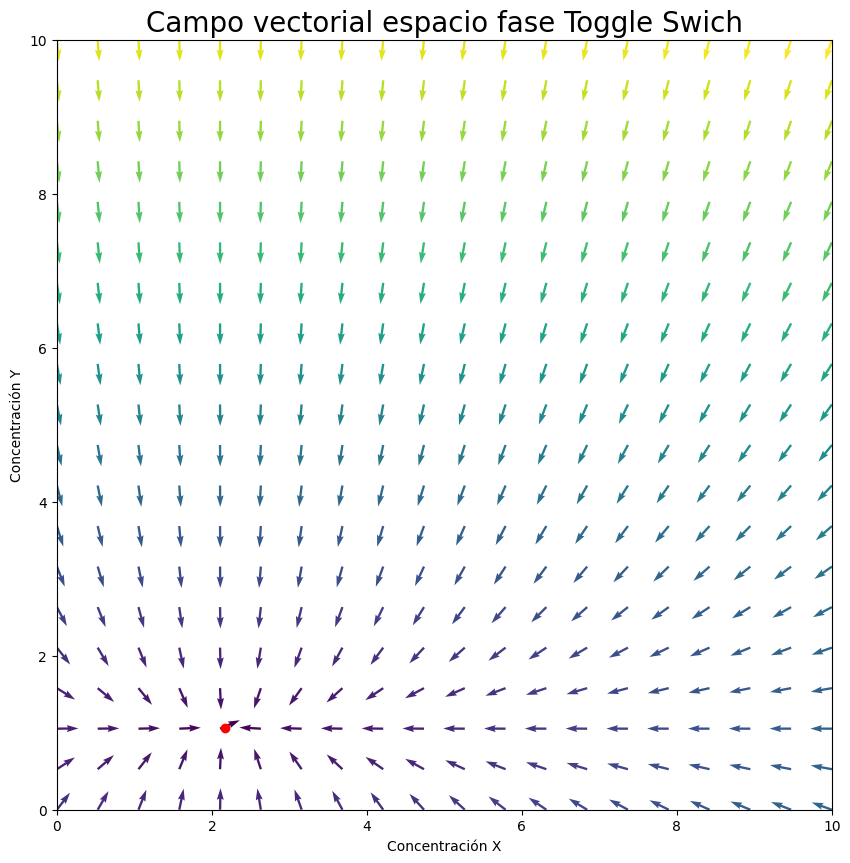

In [39]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values =primer_cuadrante_reales[1]

y1 = np.linspace(0, 10, 20)
y2 = np.linspace(0, 10, 20)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')
plt.show()

## Encontramos puntos de equilibro datos predecidos

In [40]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b2pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

(2.0, 0.888888888888889)


## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

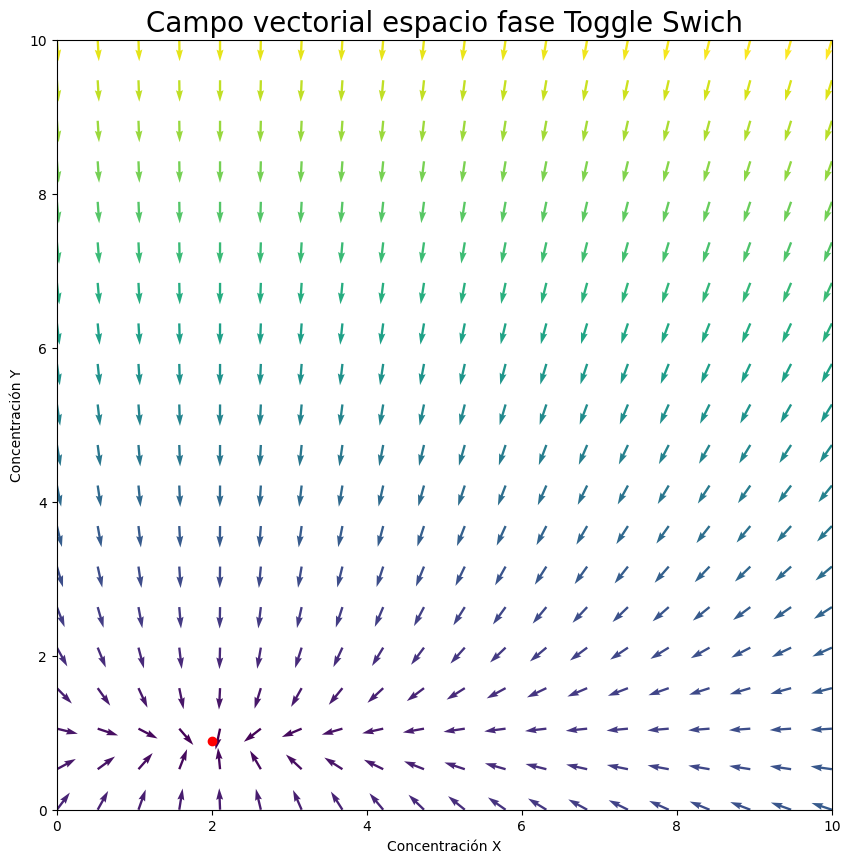

In [41]:
import matplotlib.pyplot as plt

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
    dY_dt = a2pred/(1+X**npred)-d2pred*Y+b2pred

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1pred = np.linspace(x_range_neg, x_range_pos, 20)
y2pred = np.linspace(y_range_neg, y_range_pos, 20)

Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
t1 = 0

upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

NI, NJ = Y1.shape

u1pred, v1pred = f(t1, [Y1, Y2])
upred, vpred = f(t1, [Y1, Y2])
Mpred = (np.hypot(upred, vpred))
upred /= Mpred
vpred /= Mpred


x_valuespred = primer_cuadrante_predecidos[0]
y_valuespred =primer_cuadrante_predecidos[1]
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.scatter(x_valuespred, y_valuespred, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos ambos

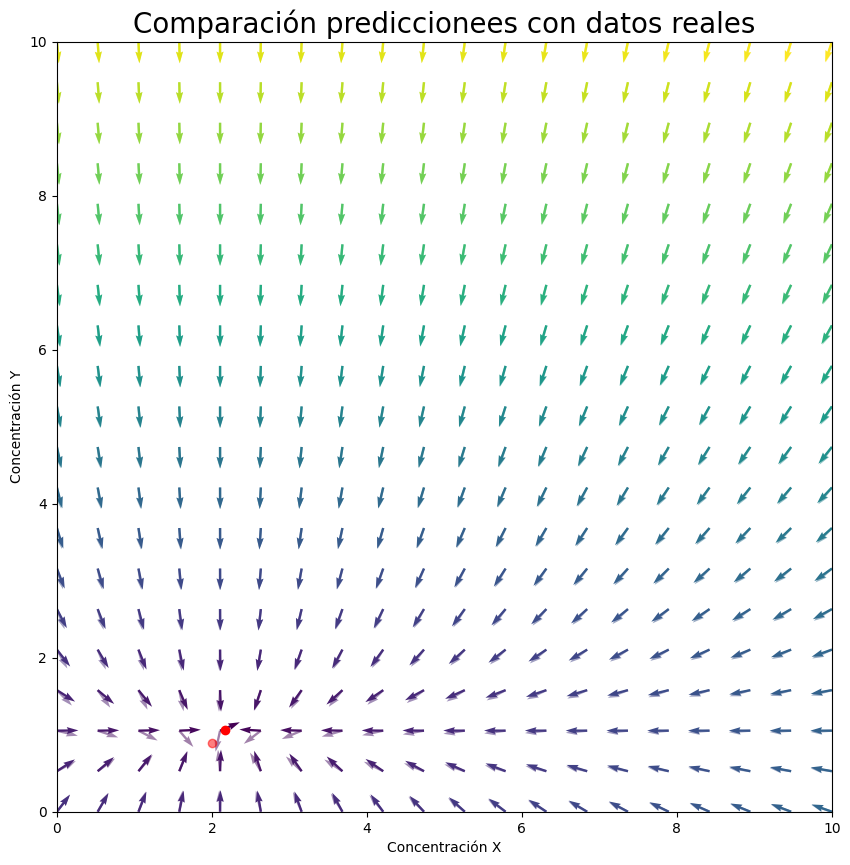

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))

# Primero graficamos la predicción, que debería ser más clara (alpha < 1)
Q = ax.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy', alpha=0.5)

# Luego, graficamos los datos originales, que serán más oscuros (alpha = 1)
Q1 = ax.quiver(Y1, Y2, u, v, M, angles='xy', alpha=1)

ax.scatter(x_valuespred, y_valuespred, color='red', alpha = 0.5)
ax.scatter(x_values, y_values, color='red', alpha = 1)
ax.set_title('Comparación prediccionees con datos reales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

plt.show()

## Graficamos las diferencias

59.34212808374971


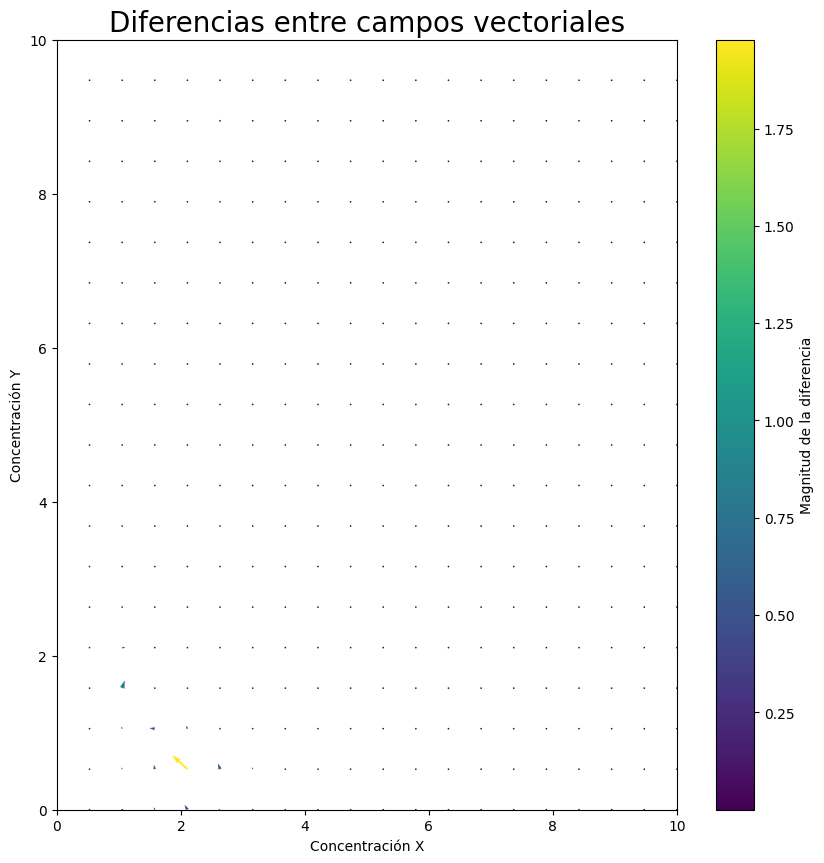

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Ahora calculamos la magnitud
#M_diff = np.hypot(u_diff2, v_diff2)
M_diff = np.hypot(u_diff, v_diff)

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30
print(rango)
# Escala para las flechas. Aumenta este valor si las flechas son demasiado grandes.

# Graficamos las diferencias
#Q = ax.quiver(Y1, Y2, u_diff2, v_diff2, M_diff, angles='xy')
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy', scale = rango)
#Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy')


ax.set_title('Diferencias entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia')

plt.show()

## Errores relativos

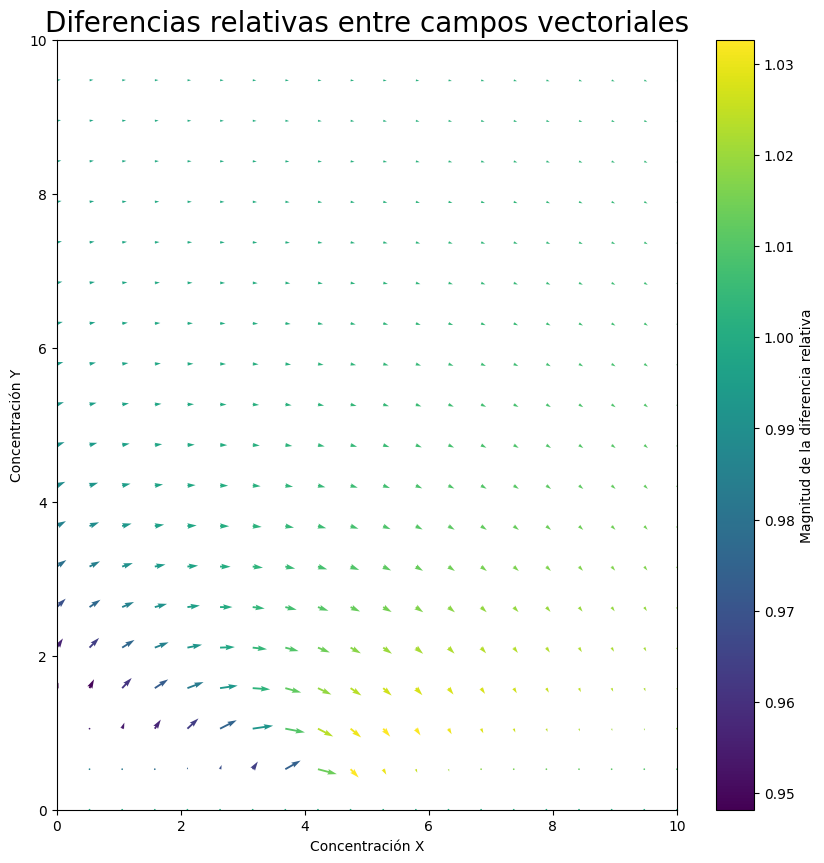

In [87]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7

# Calculamos la magnitud del vector original y de la diferencia
M_orig = np.hypot(u1, v1) + epsilon
M_diff = np.hypot(u1pred, v1pred)

# Calculamos la diferencia relativa
M_diff_rel = M_diff / M_orig

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30

# Graficamos las diferencias relativas
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff_rel, angles='xy', scale = rango)

ax.set_title('Diferencias relativas entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia relativa')

plt.show()

In [88]:
max_index_flattened = M_diff_rel.argmax()
max_coords = np.unravel_index(max_index_flattened, M_diff_rel.shape)
M_orig[max_coords]
print('El valor máximo de error relativo es de:', M_diff_rel.max() )
print('El valor de u1 en el error relativo máximo es:',u1[max_coords])
print('El valor de u1pred en el error relativo máximo es:',u1pred[max_coords])
print('El valor de v1 en el error relativo máximo es:',v1[max_coords])
print('El valor de v1pred en el error relativo máximo es:',v1pred[max_coords])

El valor máximo de error relativo es de: 1.0326134791146624
El valor de u1 en el error relativo máximo es: -7.257625008645132
El valor de u1pred en el error relativo máximo es: -7.783249187357352
El valor de v1 en el error relativo máximo es: -8.160104440233873
El valor de v1pred en el error relativo máximo es: -8.160104440233873


In [89]:
# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7

# Calculamos la magnitud del vector original y de la diferencia
M_orig = np.hypot(u, v) + epsilon
M_diff = np.hypot(u_diff, v_diff)

# Calculamos la diferencia relativa
M_diff_rel = M_diff / M_orig

# Aplicamos el filtro para la diferencia relativa mayor a 0.05
mask = M_diff_rel > 0.05

# Calculamos el porcentaje de puntos que cumplen con la condición
porcentaje = np.mean(mask) * 100

print(f"El porcentaje de puntos cuyo error relativo es mayor a 0.05 es {porcentaje:.2f}%")

El porcentaje de puntos cuyo error relativo es mayor a 0.05 es 2.75%


## Simulamos 10,000 veces

In [90]:
import numpy as np
import random
from scipy.optimize import fsolve

# Listas para almacenar los resultados
porcentajes = []

# Repetimos el proceso 10 veces
for repetir in range(10000):
    campvec = []
    coef = []
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b2

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos = 10

    y1 = np.linspace(x_range_neg, x_range_pos, 20)
    y2 = np.linspace(y_range_neg, y_range_pos, 20)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
#    print(coef1)
    
    campvec = np.array(campvec)

    
    campvecnone = campvec[None, :]
    campvecnone = np.transpose(campvecnone, (0,2,3,1))
    
    new_predictions = new_model.predict(campvecnone)
    new_predictions = np.round(new_predictions)
    new_predictions = np.clip(new_predictions, 0, None)
#    print(new_predictions)
    
    
    a1pred = new_predictions[0,0]
    a2pred = new_predictions[0,1]
    b1pred = new_predictions[0,2]
    b2pred = new_predictions[0,3]
    d1pred = new_predictions[0,4]
    d2pred = new_predictions[0,5]
    npred = new_predictions[0,6]
    
    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
        dY_dt = a2pred/(1+X**npred)-d2pred*Y+b2pred

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos = 10

    y1pred = np.linspace(x_range_neg, x_range_pos, 20)
    y2pred = np.linspace(y_range_neg, y_range_pos, 20)

    Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
    t1 = 0

    upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

    NI, NJ = Y1.shape

    u1pred, v1pred = f(t1, [Y1, Y2])
    upred, vpred = f(t1, [Y1, Y2])
    Mpred = (np.hypot(upred, vpred))
    upred /= Mpred
    vpred /= Mpred

 # Calculamos las diferencias
    u_diff = u - upred
    v_diff = v - vpred

    # Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
    epsilon = 1e-7

    # Calculamos la magnitud del vector original y de la diferencia
    M_orig = np.hypot(u, v) + epsilon
    M_diff = np.hypot(u_diff, v_diff)

    # Calculamos la diferencia relativa
    M_diff_rel = M_diff / M_orig

    # Aplicamos el filtro para la diferencia relativa mayor a 0.05
    mask = M_diff_rel > 0.05

    # Calculamos el porcentaje de puntos que cumplen con la condición
    porcentaje = np.mean(mask) * 100

    # Almacenamos el resultado en la lista
    porcentajes.append(porcentaje)

    print(f"El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración {repetir+1} es {porcentaje:.2f}%")

# Muestra todos los porcentajes al final
print("Porcentajes para las 10 iteraciones:", porcentajes)

# Calcula y muestra el promedio de los porcentajes
promedio = np.mean(porcentajes)
print(f"El promedio de los porcentajes es {promedio:.2f}%")


--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 1 es 97.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 2 es 96.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 3 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 4 es 96.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 5 es 81.25%
--------------------------------------------
1/1 [=========================

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 45 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 46 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 47 es 36.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 48 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 49 es 98.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de 

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 133 es 93.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 134 es 93.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 135 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 136 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 137 es 92.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 177 es 90.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 178 es 96.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 179 es 91.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 180 es 96.50%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 181 es 97.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 221 es 98.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 222 es 98.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 223 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 224 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 225 es 96.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 265 es 95.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 266 es 99.50%
--------------------------------------------
1/1 [==============================] - 0s 9ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 267 es 95.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 268 es 90.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 269 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje 

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 309 es 97.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 310 es 95.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 311 es 87.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 312 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 313 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcenta

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 353 es 93.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 354 es 95.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 355 es 98.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 356 es 99.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 357 es 93.50%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 397 es 93.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 398 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 399 es 98.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 400 es 99.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 401 es 99.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 441 es 93.50%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 442 es 90.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 443 es 91.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 444 es 97.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 445 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaj

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 485 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 486 es 95.50%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 487 es 97.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 488 es 84.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 489 es 98.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 529 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 530 es 93.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 531 es 80.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 532 es 97.50%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 533 es 71.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaj

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 573 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 574 es 91.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 575 es 55.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 576 es 98.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 577 es 94.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 617 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 618 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 619 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 620 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 621 es 99.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcenta

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 661 es 96.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 662 es 85.50%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 663 es 93.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 664 es 94.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 665 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 705 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 706 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 707 es 92.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 708 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 709 es 99.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcenta

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 749 es 98.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 750 es 62.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 751 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 752 es 95.50%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 753 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcenta

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 793 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 794 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 795 es 95.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 796 es 98.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 797 es 90.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcenta

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 837 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 838 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 839 es 87.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 840 es 98.50%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 841 es 83.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje

1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 881 es 93.25%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 882 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 9ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 883 es 84.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 884 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 885 es 83.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaj

1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 925 es 81.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 926 es 99.00%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 927 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 928 es 95.75%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 929 es 99.25%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje

1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 969 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 970 es 93.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 971 es 100.00%
--------------------------------------------
1/1 [==============================] - 0s 11ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 972 es 99.75%
--------------------------------------------
1/1 [==============================] - 0s 10ms/step
El porcentaje de puntos cuyo error relativo es mayor a 0.05 en la iteración 973 es 95.00%
--------------------------------------------
1/1 [==============================] - 0s 12ms/step
El porcenta

KeyboardInterrupt: 